In [1]:
# -*- coding: utf-8 -*-

import os
import sys
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from features import FeatureExtractor
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import pickle


# %%---------------------------------------------------------------------------
#
#		                 Load Data From Disk
#
# -----------------------------------------------------------------------------

data_dir = 'data' # directory where the data files are stored

output_dir = 'training_output' # directory where the classifier(s) are stored

if not os.path.exists(output_dir):
	os.mkdir(output_dir)

# the filenames should be in the form 'speaker-data-subject-1.csv', e.g. 'speaker-data-Erik-1.csv'.

class_names = [] # the set of classes, i.e. speakers

data = np.zeros((0,8002)) #8002 = 1 (timestamp) + 8000 (for 8kHz audio data) + 1 (label)
for filename in os.listdir(data_dir):
	if filename.endswith(".csv") and filename.startswith("speaker-data"):
		filename_components = filename.split("-") # split by the '-' character
		speaker = filename_components[2]
		print("Loading data for {}.".format(speaker))
		if speaker not in class_names:
			class_names.append(speaker)
		speaker_label = class_names.index(speaker)
		sys.stdout.flush()
		data_file = os.path.join(data_dir, filename)
		data_for_current_speaker = np.genfromtxt(data_file, delimiter=',')
		print("Loaded {} raw labelled audio data samples.".format(len(data_for_current_speaker)))
		sys.stdout.flush()
		data = np.append(data, data_for_current_speaker, axis=0)

print("Found data for {} speakers : {}".format(len(class_names), ", ".join(class_names)))
# %%---------------------------------------------------------------------------
#
#		                Extract Features & Labels
#
# -----------------------------------------------------------------------------

# Update this depending on how you compute your features
n_features = 1031

print("Extracting features and labels for {} audio windows...".format(data.shape[0]))
sys.stdout.flush()

X = np.zeros((0,n_features))
y = np.zeros(0,)

# change debug to True to show print statements we've included:
feature_extractor = FeatureExtractor(debug=False) 

nr_total_windows = 0
nr_bad_windows = 0
nr_windows_with_zeros = 0

for i,window_with_timestamp_and_label in enumerate(data):
    window = window_with_timestamp_and_label[1:-1]
    label = data[i,-1]
    nr_total_windows += 1
    try:
        x = feature_extractor.extract_features(window)
        if (len(x) != X.shape[1]):
            print("Received feature vector of length {}. Expected feature vector of length {}.".format(len(x), X.shape[1]))
        X = np.append(X, np.reshape(x, (1,-1)), axis=0)
        y = np.append(y, label)
    except KeyError as e:
        print(e)
        nr_bad_windows += 1
        if np.all((window == 0)):
            nr_windows_with_zeros += 1
print("{} windows found".format(nr_total_windows))
print("{} bad windows found, with {} windows with only zeros".format(nr_bad_windows, nr_windows_with_zeros))
    
print("Finished feature extraction over {} windows".format(len(X)))
print("Unique labels found: {}".format(set(y)))
sys.stdout.flush()


Loading data for anger.
Loaded 1149 raw labelled audio data samples.
Loading data for happy.
Loaded 1083 raw labelled audio data samples.
Loading data for sad.
Loaded 1111 raw labelled audio data samples.
Found data for 3 speakers : anger, happy, sad
Extracting features and labels for 3343 audio windows...


C:\Users\harsh\final_project\features.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.mean(np.fft.fft(window, axis = 0).astype(float))


1
1
1
1
1
1
1
3343 windows found
7 bad windows found, with 7 windows with only zeros
Finished feature extraction over 3336 windows
Unique labels found: {0.0, 1.0, 2.0}


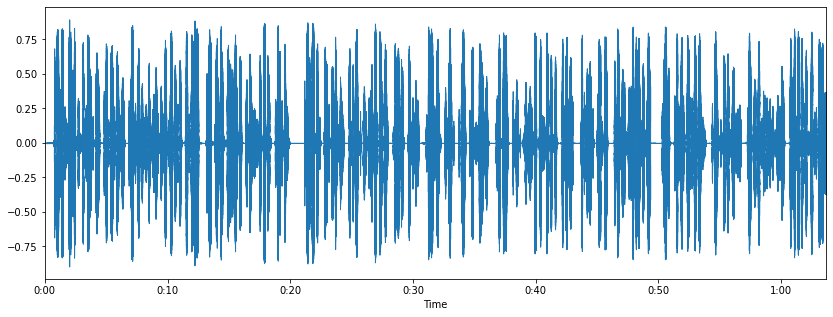

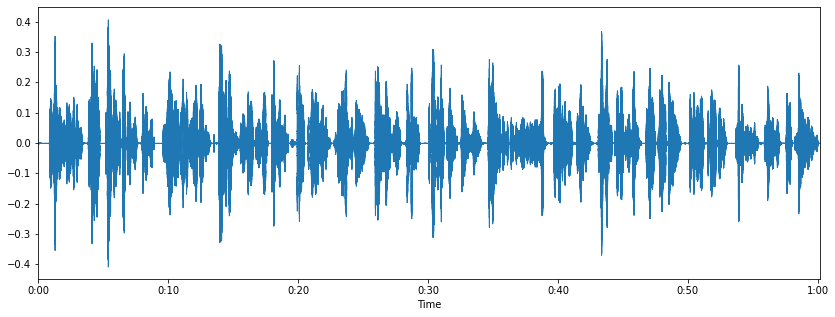

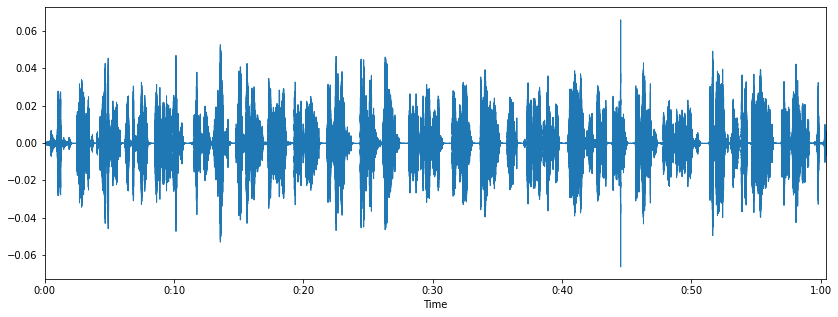

In [3]:
import librosa
audio_data1 = 'main-data-anger-0.wav'
audio_data2 = 'main-data-happy-1.wav'
audio_data3 = 'main-data-sad-2.wav'
x1 , sr1 = librosa.load(audio_data1)
x2 , sr2 = librosa.load(audio_data2)
x3 , sr3 = librosa.load(audio_data3)

librosa.load(audio_data1, sr=44100)
librosa.load(audio_data2, sr=44100)
librosa.load(audio_data3, sr=44100)


%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x1, sr=sr1)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x2, sr=sr2)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x3, sr=sr3)

In [4]:
# %%---------------------------------------------------------------------------
#
#		                Train & Evaluate Classifier
#
# -----------------------------------------------------------------------------

n = len(y)
n_classes = len(class_names)

print("\n")
print("---------------------- Decision Tree -------------------------")

total_accuracy = 0.0
total_precision = [0.0, 0.0, 0.0]
total_recall = [0.0, 0.0, 0.0]

cv = KFold(n_splits=10, shuffle=True, random_state=None)
for i, (train_index, test_index) in enumerate(cv.split(X)):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)
	print("Fold {} : Training decision tree classifier over {} points...".format(i, len(y_train)))
	sys.stdout.flush()
	tree.fit(X_train, y_train)
	print("Evaluating classifier over {} points...".format(len(y_test)))

	# predict the labels on the test data
	y_pred = tree.predict(X_test)

	# show the comparison between the predicted and ground-truth labels
	conf = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

	accuracy = np.sum(np.diag(conf)) / float(np.sum(conf))
	precision = np.nan_to_num(np.diag(conf) / np.sum(conf, axis=1).astype(float))
	recall = np.nan_to_num(np.diag(conf) / np.sum(conf, axis=0).astype(float))

	total_accuracy += accuracy
	total_precision += precision
	total_recall += recall
   
print("The average accuracy is {}".format(total_accuracy/10.0))  
print("The average precision is {}".format(total_precision/10.0))    
print("The average recall is {}".format(total_recall/10.0))  

print("Training decision tree classifier on entire dataset...")
tree.fit(X, y)

classifier_filename='classifier.pickle'
print("Saving best classifier to {}...".format(os.path.join(output_dir, classifier_filename)))
with open(os.path.join(output_dir, classifier_filename), 'wb') as f: # 'wb' stands for 'write bytes'
	pickle.dump(tree, f)



---------------------- Decision Tree -------------------------
Fold 0 : Training decision tree classifier over 3002 points...
Evaluating classifier over 334 points...
Fold 1 : Training decision tree classifier over 3002 points...
Evaluating classifier over 334 points...
Fold 2 : Training decision tree classifier over 3002 points...
Evaluating classifier over 334 points...
Fold 3 : Training decision tree classifier over 3002 points...
Evaluating classifier over 334 points...
Fold 4 : Training decision tree classifier over 3002 points...
Evaluating classifier over 334 points...
Fold 5 : Training decision tree classifier over 3002 points...
Evaluating classifier over 334 points...
Fold 6 : Training decision tree classifier over 3003 points...
Evaluating classifier over 333 points...
Fold 7 : Training decision tree classifier over 3003 points...
Evaluating classifier over 333 points...
Fold 8 : Training decision tree classifier over 3003 points...
Evaluating classifier over 333 points...

[[ 90   6  11]
 [ 42  47  28]
 [  0   6 103]]


<ipython-input-5-631f2355bc74>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-5-631f2355bc74>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


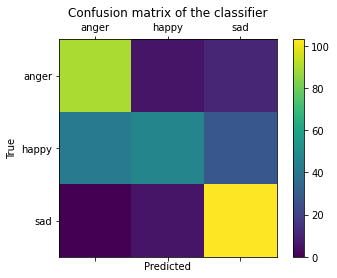

In [5]:
print(conf)
labels = ['anger', 'happy', 'sad']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()